# Computer vision tutorial

This tutorial will go through several common classical computer vision methods. The topics covered will be:

## Segmentation methods
- Thresholding methods
    - Histogram-based methods
- Edge detection methods (Canny edge detector)
- Euclidean distance transform
- Watershedding

## Feature detection methods
- SIFT
- SURF
- ORB

Throughout this pipeline I'll use a standard photograph when possible, and an easier-to-handle image from my research when not.

## Preparation

First, let's load in some of the computer vision packages for Python:
- `numpy` arrays are the standard structure for storing images (value = pixel value).
- `OpenCV`: Open source CV tools, includes some patented algorithms, so should be used with caution in commercial settings. Pip install instructions [here](https://docs.opencv.org/3.4.1/d2/de6/tutorial_py_setup_in_ubuntu.html)
- `scipy.ndimage` [here](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- `scikit-image` (mostly just wrappers for scipy's ndimage functions) [here](http://scikit-image.org/)

In [38]:
# Load dependencies
import numpy as np
from cv2 import cv2
from scipy import ndimage as ndi
from scipy import signal
from skimage import io
from skimage import feature
import skimage
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 6) # change default figure size

Next, let's load in the image files we're working with. Change `tutorial_dir` to ref the location where you installed this repo.

In [2]:
tutorial_dir = '/Users/nweir/Dropbox/code/insight/tutorials/NW_insight_cv_tutorial/'
microscopy_file = 'microscopy.tif'
doggo_file = 'doggo.jpg'
microscopy = io.imread(tutorial_dir + microscopy_file)
doggo = io.imread(tutorial_dir + doggo_file)

In [3]:
doggo.shape

(1220, 1232, 3)

`microscopy` is a 125x125 array of 8-bit values, where each array element corresponds to a pixel. The value is the pixel intensity.

`doggo` is a 1220x1232x3 RGB array.

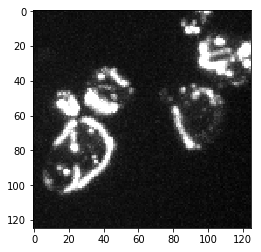

In [4]:
plt.imshow(microscopy, cmap='gray')

In case anyone is wondering, that's what yeast mitochondria and peroxisomes look like. Often with noisy data (like the microscopy data), it can help to smooth the image with a gaussian filter to clean up noise.

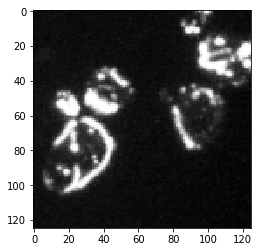

In [5]:
microscopy = ndi.gaussian_filter(microscopy, sigma=(0.5,0.5))
plt.imshow(microscopy, cmap='gray')

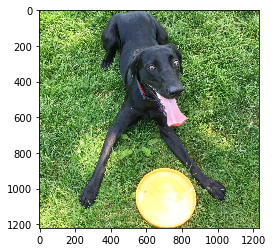

In [6]:
plt.imshow(doggo)

To simplify everything, I'm going to work on a grayscale version of this image.

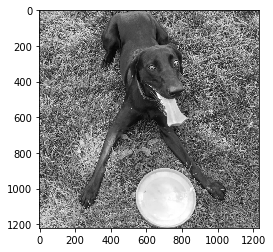

In [7]:
gray_doggo = cv2.cvtColor(doggo, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_doggo, cmap='gray')

## Segmentation

### Part 1: Thresholding
Thresholding is the simple process of generating a binary (or multi-class) cutoff to separate images by pixel intensity. This is often the first step in object detection using classical computer vision techniques.

#### Histogram-based methods
Histogram-based segmentation methods generate a histogram of pixel intensities and try to find natural cuts between those intensities to generate separate groups. We'll start out by looking at histograms of pixel intensities in the cells and Charlotte.

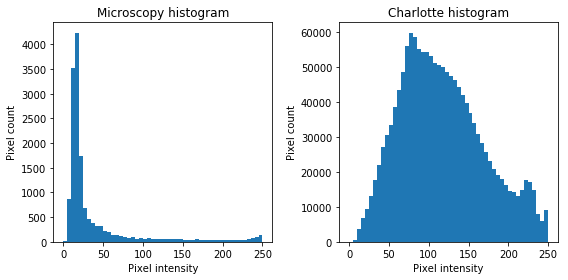

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
# need to flatten arrays for generating 1D histograms
plt.hist(microscopy.flatten(), bins=np.arange(0,255,5))
plt.title('Microscopy histogram')
plt.xlabel('Pixel intensity')
plt.ylabel('Pixel count')
plt.subplot(1,2,2)
plt.ylabel('Pixel count')
plt.hist(gray_doggo.flatten(), bins=np.arange(0,255,5))
plt.xlabel('Pixel intensity')
plt.title('Charlotte histogram')
plt.tight_layout()


Histogram-based methods generate cuts in the image based on the histogram to separate objects based on intensity. This can be done manually (as I'll do here) or using methods like KMeans or Gaussian Mixture Models.

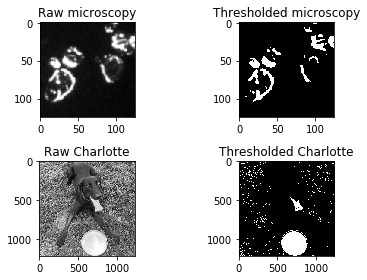

In [9]:
microscopy_threshold = 150
charlotte_threshold = 200
plt.subplot(2,2,1)
plt.imshow(microscopy, cmap='gray')
plt.title('Raw microscopy')
plt.subplot(2,2,2)
plt.imshow(microscopy > microscopy_threshold, cmap='gray')
plt.title('Thresholded microscopy')
plt.subplot(2,2,3)
plt.imshow(gray_doggo, cmap='gray')
plt.title('Raw Charlotte')
plt.subplot(2,2,4)
plt.imshow(gray_doggo > charlotte_threshold, cmap='gray')
plt.title('Thresholded Charlotte')
plt.tight_layout()

As you can see, this works well when there are very clear separations in intensity between the objects that you are interested in and those that you aren't. Less so in other cases. Smoothing can help with this sometimes:

Text(0.5,1,'Thresholded smoothed Charlotte')

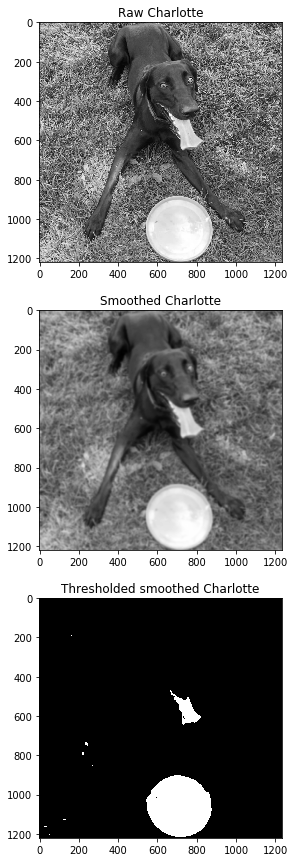

In [10]:
smooth_doggo = ndi.gaussian_filter(gray_doggo, sigma=(4,4))
plt.figure(figsize=(5,15))
plt.subplot(3,1,1)
plt.imshow(gray_doggo, cmap='gray')
plt.title('Raw Charlotte')
plt.subplot(3,1,2)
plt.imshow(smooth_doggo, cmap='gray')
plt.title('Smoothed Charlotte')
plt.subplot(3,1,3)
plt.imshow(smooth_doggo > charlotte_threshold, cmap='gray')
plt.title('Thresholded smoothed Charlotte')

Good news if you want to find frisbees and dog tongues!

### Part 2: Edge detection
Absolute thresholds are often imperfect tools for object detection. For example, having a bright background can make segmentation of _even brighter_ objects, without losing dim objects on dimmer backgrounds. For example, consider the image below:

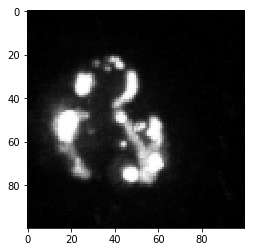

In [11]:
microscopy_2 = io.imread(tutorial_dir + 'microscopy_2.tif')
microscopy_2 = ndi.gaussian_filter(microscopy_2, sigma=(0.5,0.5))
plt.imshow(microscopy_2, cmap='gray')

Imagine we wanted to find _all_ of the dots in this image, but not the tubes. (This is a challenge I often faced in my PhD). Using pixel intensities won't work, because if we set the threshold too low, we'll get all of the tubes too; if we set it too high, we'll miss the dim dots.

Text(0.5,1,'High cutoff, misses dim dots')

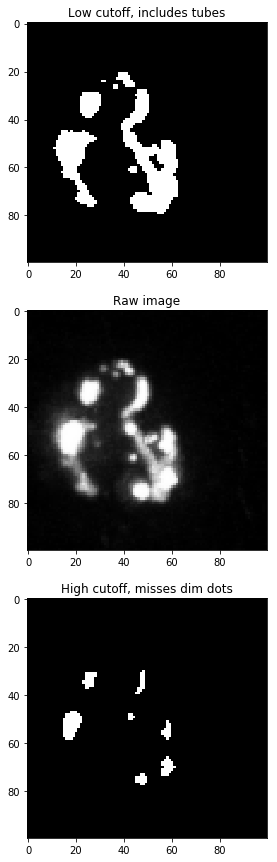

In [12]:
figure = plt.figure(figsize=(5,15))
plt.subplot(3,1,1)
plt.imshow(microscopy_2 > 100, cmap='gray')
plt.title('Low cutoff, includes tubes')
plt.subplot(3,1,2)
plt.imshow(microscopy_2, cmap='gray')
plt.title('Raw image')
plt.subplot(3,1,3)
plt.imshow(microscopy_2 > 250, cmap='gray')
plt.title('High cutoff, misses dim dots')

So, how can we separate overlapping objects? Using edge detection methods, such as the [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector). We'll return to the original microscopy image as an example.

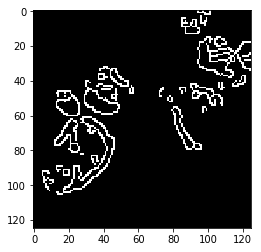

In [13]:
canny_microscopy = cv2.Canny(microscopy, 100,200)
plt.imshow(canny_microscopy, cmap='gray')

We can try to fill the holes here, but there are some small gaps and this will have problems:

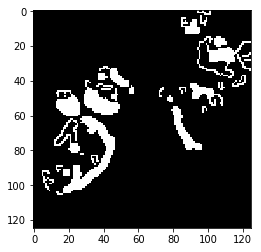

In [14]:
filled_microscopy = ndi.binary_fill_holes(canny_microscopy)
plt.imshow(filled_microscopy, cmap='gray')

We can use binary morphology operations to close small gaps in the image (see [this page](https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm) for more information)

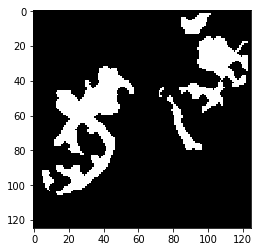

In [15]:
# create structuring element for binary closing
s = ndi.morphology.generate_binary_structure(2,1)
strel = np.zeros((5,5))
strel[2,2] = 1
strel = ndi.binary_dilation(strel, s, iterations=2)
# perform closing
canny_microscopy = ndi.binary_closing(canny_microscopy, structure=strel)
# fill holes
filled_microscopy = ndi.binary_fill_holes(canny_microscopy)
plt.imshow(filled_microscopy, cmap='gray')

As you can see, this filles the holes, but leaves other issues to address (merging of objects, filling holes that hsouldn't be filled, etc.) - these issues can sometimes be addressed by performing binary erosion operations on the output, but also explain why newer CV methods are preferred when available.

Just for fun: What do the edges look like on the picture of Charlotte?

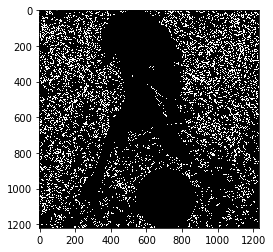

In [16]:
doggo_edges = cv2.Canny(gray_doggo, 150,600)
plt.imshow(doggo_edges, cmap='gray')

This clearly doesn't work well when you have much too many edges. Sometimes you can set the threshold high enough for what gets called an edge to handle these types of issues, but when there's a mix of very strong and very weak edges in an image it's often hard or impossible.

### Watershed segmentation
Watershed segmentation is a very common approach for identifying individual objects within an image. This can be particularly helpful if you have multiple objects touching each other which you want to split. See https://en.wikipedia.org/wiki/Watershed_(image_processing) for theory.

Watershed segmentation has two steps:
1. Identify object centers (Euclidean Distance transformation)
2. Use a watershed algorithm to segment them

We'll use 1. to identify unique objects from microscopy data and 2. to identify Charlotte's frisbee.

Text(0.5,1,'Thresholded image')

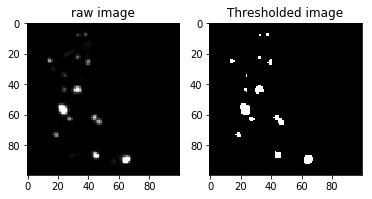

In [22]:
# object ID from microscopy data
raw_im = io.imread(tutorial_dir + 'microscopy_3.tif')
thresholded_im = raw_im > 50
figure = plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(raw_im, cmap='gray')
plt.title('raw image')
plt.subplot(1,2,2)
plt.imshow(thresholded_im, cmap='gray')
plt.title('Thresholded image')

As you can see, two objects in the center of this image are merged because they are so close to each other. Let's separate each peroxisome here. To do so, we'll perform a distance transformation that assigns each foreground pixel a value corresponding to its distance to the nearest background pixel.

Text(0.5,1,'Distance-transformed peroxisomes')

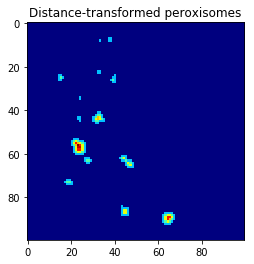

In [24]:
# Euclidean distance transform
dist_xform = ndi.morphology.distance_transform_edt(thresholded_im)
plt.imshow(dist_xform, cmap='jet')
plt.title('Distance-transformed peroxisomes')

Next, we'll get the local maxima from this image to find the peroxisome centers. This requires a few steps like smoothing the distance map and cleaning up the background.

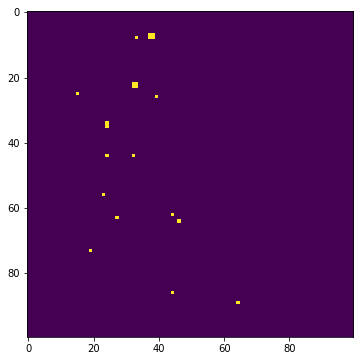

In [72]:
smooth_dist = ndi.gaussian_filter(dist_xform, sigma=(0.5,0.5))

# the following modified from here: https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
neighborhood = ndi.generate_binary_structure(2,2)

#apply the local maximum filter; all pixel of maximal value 
#in their neighborhood are set to 1
local_max = ndi.maximum_filter(smooth_dist, footprint=neighborhood)==smooth_dist
#local_max is a mask that contains the peaks we are 
#looking for, but also the background.
#In order to isolate the peaks we must remove the background from the mask.

#we create the mask of the background
background = (thresholded_im==0)

#a little technicality: we must erode the background in order to 
#successfully subtract it form local_max, otherwise a line will 
#appear along the background border (artifact of the local maximum filter)
eroded_background = ndi.binary_erosion(background, structure=neighborhood, iterations=3, border_value=1)

#we obtain the final mask, containing only peaks, 
#by removing the background from the local_max mask (xor operation)
maxima = local_max ^ eroded_background

plt.imshow(maxima)

Now that we have the "seed points" for watershedding, we can perform segmentation.

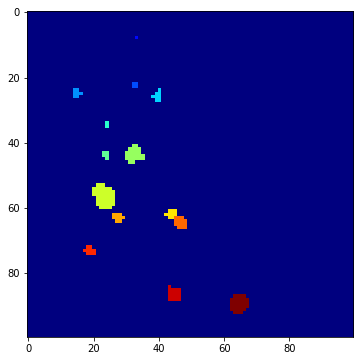

In [77]:
from skimage.measure import label
from skimage.morphology import watershed
labels = label(maxima, connectivity=1) # individually label each seed point with a different numeric ID
labels[labels == 1] = 0  # remove background labels
labeled_pexs = watershed(-smooth_dist, labels, mask=thresholded_im)
plt.imshow(labeled_pexs, cmap='jet')


Huzzah! We have successfully segmented the peroxisomes, including separating the touching objects. Now each object is labeled by different numeric IDs in the image.

## Feature detection algorithms
SIFT, SURF, ORB, and other feature detection algorithms are implemented in OpenCV, a fantastic computer vision library for python. Some of these algorithms are proprietary and shouldn't be used for commercial purposes without a license.

For the theory behind these algorithms, see here:  
- [SIFT](https://docs.opencv.org/3.4.1/da/df5/tutorial_py_sift_intro.html)  
- [SURF](https://docs.opencv.org/3.0-alpha/doc/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html)  
- [ORB](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html)

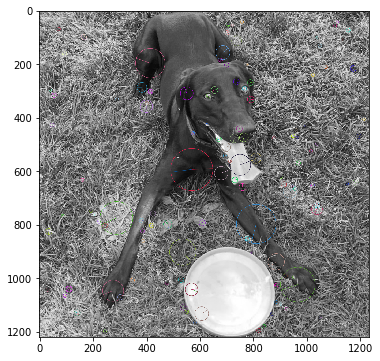

In [87]:

sift = cv2.xfeatures2d.SIFT_create(nfeatures=150)
kp = sift.detect(smooth_doggo,None)  # we need to use the smoothed version because the sharpness makes too many edges.
img = cv2.drawKeypoints(gray_doggo,kp,gray_doggo, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

Here we've found information-rich points on this image of Charlotte with her frisbee.

These features are often similar in related images. For example, they can be used to match realte